General optimizations:
- Diro2C generation algorithm could take into account possible values for categorical features or integer features
- scikit-learn Decision tree implementation does not support categorical values, they are currently only approximated by converting them to numbers. Look into alternative implementations or encode values
- it would be better for the understanding, to see how rules evolve with increasing max depth. I used unix diff for that
- general rule for determining, how far to increase max depth parameter

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c, get_generated_data
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity

In [2]:
with open('data/task.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
def get_predicted_rules(indices=None):
    indices = y_true if indices is None else indices
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    return pd.Series(pred_rule_nos, index=indices)

# Explanations

In [ ]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'explanations/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

This was run on a different machine (Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz):
- (False, False)... 0:23:27.003971
- (False, True)... 0:46:55.708892
- (True, False)... 1:10:22.483679
- (True, True)... 1:33:50.727428

## $(0,1)$

In [6]:
focus_class = '(False, True)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [7]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [16]:
len(get_generated_data(explanation)[0])

13986

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


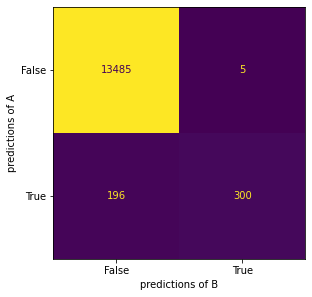

In [17]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/adult-diro2c-cf-01.pdf')

In [18]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 71.7 ms, sys: 3.99 ms, total: 75.7 ms
Wall time: 88.8 ms


2

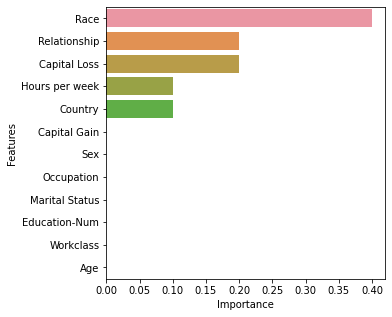

In [19]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))
plt.savefig('figures/adult-diro2c-featimp-01.pdf', bbox_inches='tight', pad_inches=0)

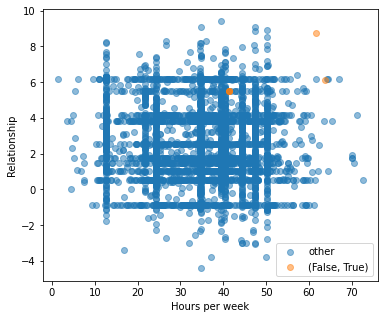

In [8]:
plot_diro2c_2d(explanation, 'Hours per week', 'Relationship', class_names=class_names)

### 3 Leafs

In [20]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(7.148984039589265e-05, 2, 3)

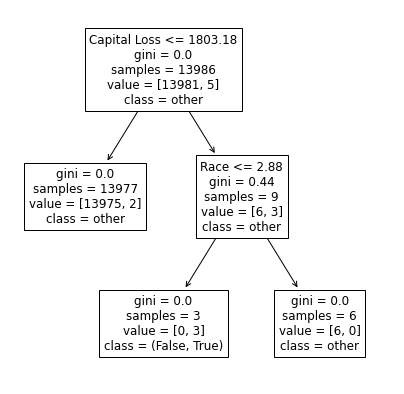

In [12]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [13]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. Race <= 3 and `Capital Loss` > 1803 => (False, True) [0, 3]


### 7 Leafs

In [21]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0, 4, 7)

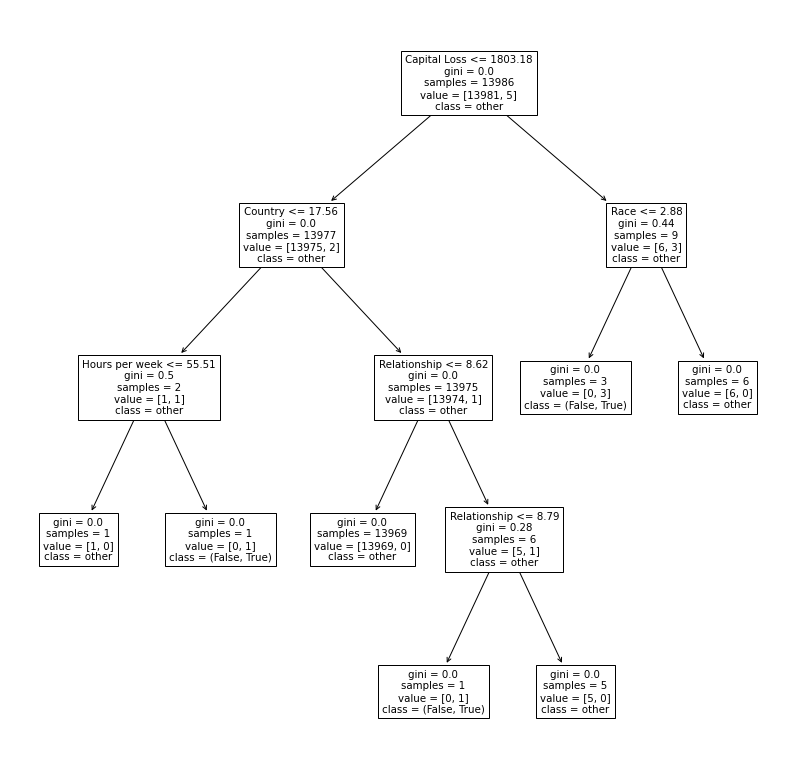

In [15]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [23]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. Race <= 3 and `Capital Loss` > 1803 => (False, True) [0, 3]
2. 9 < Relationship <= 9 and `Capital Loss` <= 1803 and Country > 18 => (False, True) [0, 1]
3. `Capital Loss` <= 1803 and `Hours per week` > 56 and Country <= 18 => (False, True) [0, 1]


In [24]:
rules = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions, latex=True)[1]
for rule in rules:
    print(f'\item if ${rule}$, then $(False, True)$')

\item if $\text{Race} \leq 3 \land \text{Capital Loss} > 1803$, then $(False, True)$
\item if $9 < \text{Relationship} \leq 9 \land \text{Capital Loss} \leq 1803 \land \text{Country} > 18$, then $(False, True)$
\item if $\text{Capital Loss} \leq 1803 \land \text{Hours per week} > 56 \land \text{Country} \leq 18$, then $(False, True)$


## $(1,0)$

In [8]:
focus_class = '(True, False)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [9]:
with open(f'explanations/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


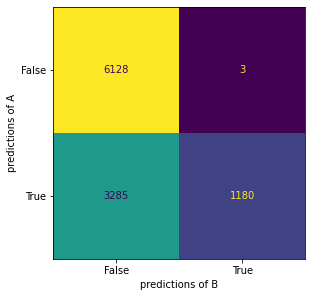

In [8]:
comparer.plot_confusion_matrix(get_generated_data(explanation)[0])
plt.savefig('figures/adult-diro2c-cf-10.pdf')

In [9]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 2.94 s, sys: 33.1 ms, total: 2.97 s
Wall time: 3.33 s


88

In [10]:
trees[-1].get_depth()

16

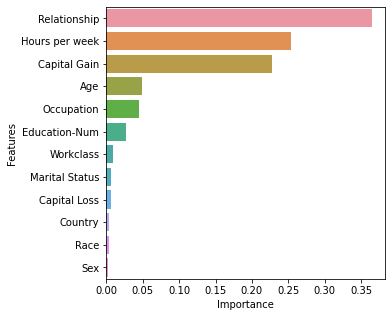

In [11]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))
plt.savefig('figures/adult-diro2c-featimp-10.pdf', bbox_inches='tight', pad_inches=0)

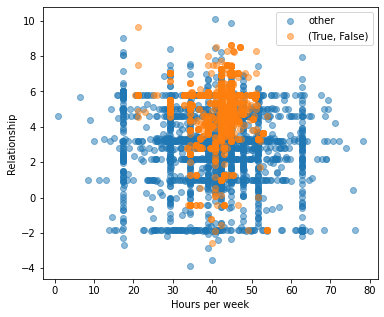

In [11]:
plot_diro2c_2d(explanation, 'Hours per week', 'Relationship', class_names=class_names)
plt.savefig('figures/adult-diro2c-10-scatter.png', bbox_inches='tight', pad_inches=0, dpi=300)

### 2 Leafs

In [24]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07222009608355562, 1, 2)

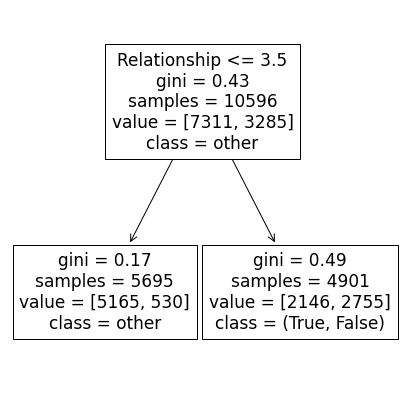

In [25]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [26]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3 => (True, False) [2146, 2755]


### 3 Leafs

In [27]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0717934304293954, 2, 3)

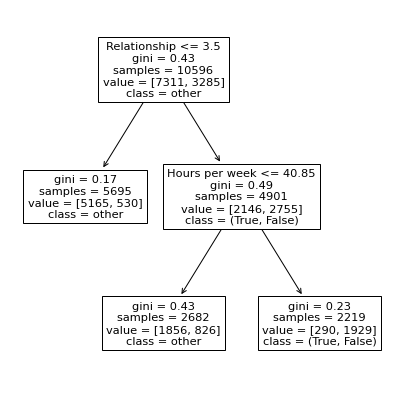

In [28]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [29]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3 and `Hours per week` > 41 => (True, False) [290, 1929]


### 4 Leafs

In [30]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.04208836461761459, 2, 4)

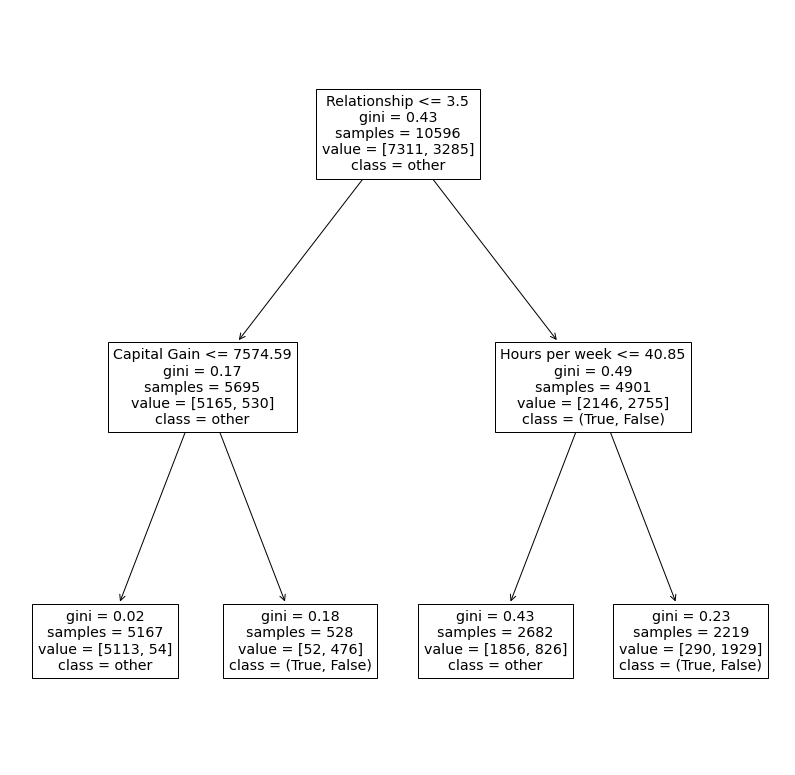

In [31]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [32]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3 and `Hours per week` > 41 => (True, False) [290, 1929]
2. Relationship <= 3 and `Capital Gain` > 7575 => (True, False) [52, 476]


### 5 Leafs

In [33]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.014232473177722943, 3, 5)

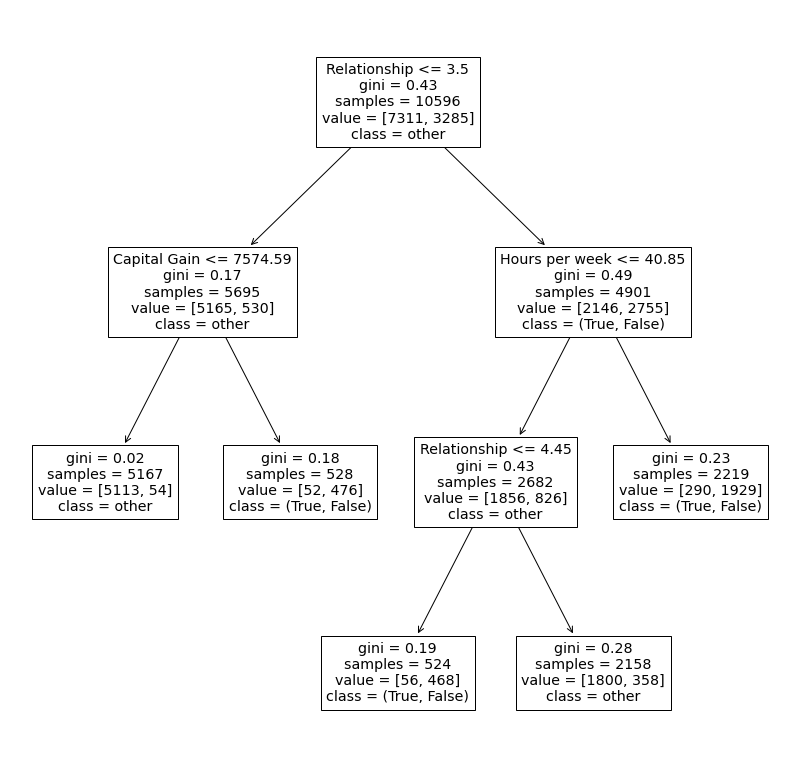

In [34]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [35]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3 and `Hours per week` > 41 => (True, False) [290, 1929]
2. Relationship <= 3 and `Capital Gain` > 7575 => (True, False) [52, 476]
3. 3 < Relationship <= 4 and `Hours per week` <= 41 => (True, False) [56, 468]


### 6 Leafs

In [36]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.013237804941543016, 4, 6)

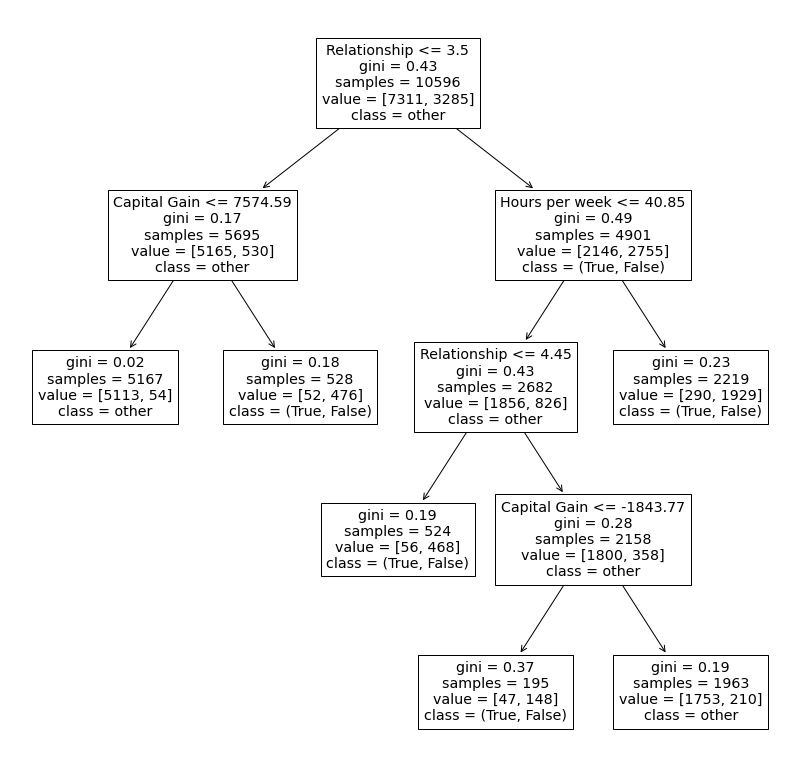

In [37]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [38]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3 and `Hours per week` > 41 => (True, False) [290, 1929]
2. Relationship <= 3 and `Capital Gain` > 7575 => (True, False) [52, 476]
3. 3 < Relationship <= 4 and `Hours per week` <= 41 => (True, False) [56, 468]
4. Relationship > 4 and `Hours per week` <= 41 and `Capital Gain` <= -1844 => (True, False) [47, 148]


### 7 Leafs

In [39]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.007023069306093532, 4, 7)

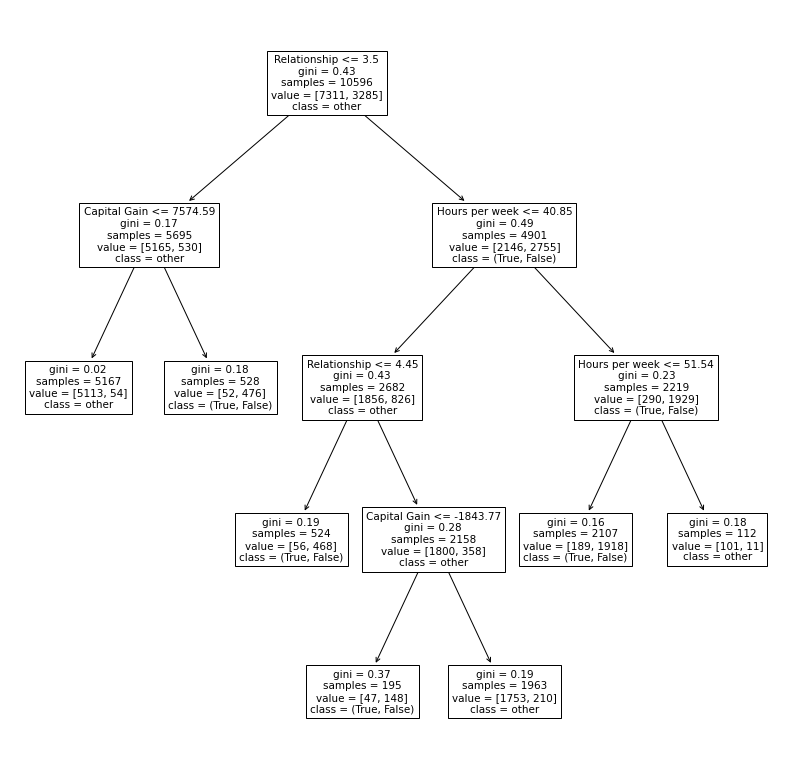

In [40]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [14]:
constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3 and 41 < `Hours per week` <= 52 => (True, False) [189, 1918]
2. Relationship <= 3 and `Capital Gain` > 7575 => (True, False) [52, 476]
3. 3 < Relationship <= 4 and `Hours per week` <= 41 => (True, False) [56, 468]
4. Relationship > 4 and `Hours per week` <= 41 and `Capital Gain` <= -1844 => (True, False) [47, 148]


In [15]:
get_predicted_rules()

34    1.0
49    3.0
53    1.0
54    1.0
60    NaN
dtype: float64

In [16]:
indices = [60]
for level, tree in enumerate(trees):
    constraints, rules, class_occurences, labels, node_ids, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions)
    pred_node_ids = tree.apply(X[indices])
    node_id_to_rule_no = lambda node_id: np.where(node_ids == node_id)[0][0] + 1 if node_id in node_ids else None
    pred_rule_nos = [node_id_to_rule_no(pred_node_id) for pred_node_id in pred_node_ids]
    if all([no != None for no in pred_rule_nos]):
        print(level)
        break

# Evaluation

In [6]:
with open('data/test.pickle', 'rb') as f:
    X_test, X_display_test, y_test = pickle.load(f)

In [7]:
test_labels = comparer.predict_mclass_diff(X_test)

In [8]:
explanations_per_class = {}
for class_name in comparer.class_names:
    with open(f'explanations/diro2c.{class_name}.pickle', 'rb') as f:
        explanations_per_class[class_name] = pickle.load(f)

In [9]:
metrics = eval_diro2c(explanations_per_class, X_test, test_labels, comparer.class_names)
metrics

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.971154,0.655163,0.782460,3854.0,"(False, False)",2.0,0.045746,1.0,1.0
1,0.955717,0.884795,0.918890,3854.0,"(False, False)",3.0,0.044047,2.0,3.0
1,0.970597,0.882200,0.924290,3854.0,"(False, False)",6.0,0.024094,3.0,8.0
1,0.970874,0.882200,0.924415,3854.0,"(False, False)",8.0,0.007216,4.0,12.0
1,0.982784,0.873897,0.925148,3854.0,"(False, False)",9.0,0.006814,4.0,13.0
...,...,...,...,...,...,...,...,...,...
1,0.705615,0.678832,0.691964,685.0,"(True, True)",255.0,0.000057,126.0,1110.0
1,0.705615,0.678832,0.691964,685.0,"(True, True)",257.0,0.000050,127.0,1121.0
1,0.700752,0.680292,0.690370,685.0,"(True, True)",262.0,0.000041,129.0,1136.0
1,0.700752,0.680292,0.690370,685.0,"(True, True)",265.0,0.000041,130.0,1145.0


<AxesSubplot:xlabel='Constraints', ylabel='F1 Score'>

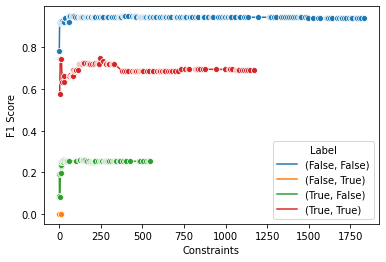

In [10]:
sns.lineplot(data=metrics, x='Constraints', y='F1 Score', hue='Label', marker='o')

In [11]:
with open('data/fidelity-diro2c.pickle', 'wb') as f:
    pickle.dump(metrics, f)

In [60]:
metrics.query('Label == "(True, False)" and Leafs == 7')

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.130692,0.928571,0.229134,238.0,"(True, False)",7.0,0.007023,4.0,11.0


In [42]:
for label in comparer.class_names:
    print(label)
    display(metrics[metrics['Label'] == label].describe())

(False, False)


,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,208.000000,208.000000,208.000000,208.0,208.000000,208.000000,208.000000,208.000000
mean,0.951882,0.937809,0.944495,3854.0,177.288462,0.001001,86.259615,693.235577
std,0.011716,0.024590,0.012662,0.0,119.975897,0.004729,59.246883,527.041260
min,0.868729,0.655163,0.782460,3854.0,2.000000,0.000000,1.000000,1.000000
25%,0.950370,0.940062,0.945009,3854.0,72.750000,0.000092,33.000000,217.750000
50%,0.952057,0.941100,0.947355,3854.0,157.500000,0.000137,74.500000,571.000000
75%,0.953354,0.944214,0.948235,3854.0,256.750000,0.000420,127.000000,1025.750000
max,0.983899,0.984951,0.949993,3854.0,423.000000,0.045746,209.000000,1830.000000


(False, True)


,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,2.0,2.0,2.0,2.0,2.000000,2.000000,2.000000,2.000000
mean,0.0,0.0,0.0,8.0,5.000000,0.000036,2.000000,5.500000
std,0.0,0.0,0.0,0.0,2.828427,0.000051,1.414214,4.949747
min,0.0,0.0,0.0,8.0,3.000000,0.000000,1.000000,2.000000
25%,0.0,0.0,0.0,8.0,4.000000,0.000018,1.500000,3.750000
50%,0.0,0.0,0.0,8.0,5.000000,0.000036,2.000000,5.500000
75%,0.0,0.0,0.0,8.0,6.000000,0.000054,2.500000,7.250000
max,0.0,0.0,0.0,8.0,7.000000,0.000071,3.000000,9.000000


(True, False)


,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,88.000000,88.000000,88.000000,88.0,88.000000,88.000000,88.000000,88.000000
mean,0.145806,0.823959,0.247492,238.0,64.602273,0.003283,31.204545,205.409091
std,0.016296,0.100395,0.027540,0.0,40.034910,0.011662,20.009285,149.314960
min,0.053047,0.193277,0.083630,238.0,2.000000,0.000000,1.000000,1.000000
25%,0.148485,0.819328,0.251605,238.0,26.750000,0.000176,10.750000,48.750000
50%,0.149031,0.840336,0.252845,238.0,65.500000,0.000300,33.000000,207.500000
75%,0.151280,0.848739,0.255858,238.0,91.250000,0.001071,43.250000,293.250000
max,0.154028,0.966387,0.259309,238.0,150.000000,0.072220,74.000000,544.000000


(True, True)


,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,123.000000,123.000000,123.000000,123.0,123.000000,123.000000,123.000000,123.000000
mean,0.674452,0.725915,0.696689,685.0,114.682927,0.000941,56.626016,449.601626
std,0.047552,0.046243,0.024970,0.0,74.180917,0.004934,36.810413,337.360748
min,0.444622,0.678832,0.575258,685.0,3.000000,0.000000,2.000000,3.000000
25%,0.682609,0.686131,0.685131,685.0,51.500000,0.000111,23.000000,141.500000
50%,0.687679,0.700730,0.691852,685.0,110.000000,0.000178,54.000000,401.000000
75%,0.700752,0.749635,0.721060,685.0,166.000000,0.000434,82.000000,677.500000
max,0.714083,0.843796,0.748220,685.0,268.000000,0.053435,132.000000,1172.000000


# Additional Material

In [46]:
explanation = explanations_per_class['(True, False)']
trees = get_pruned_trees(explanation)
tree = trees[5]
_, feature_order = get_feature_importances(tree)
tree.get_n_leaves()

7

In [47]:
constraints, rules, class_occurences, labels, rule_order = extract_rules(tree, feature_names, comparer.difference_classes, feature_order, feature_precisions, latex=True)
for rule in rules:
    print(f'\item if ${rule}$, then $(1, 0)$')

\item if $\text{Relationship} > 3 \land 41 < \text{Hours per week} \leq 52$, then $(1, 0)$
\item if $\text{Relationship} \leq 3 \land \text{Capital Gain} > 7575$, then $(1, 0)$
\item if $3 < \text{Relationship} \leq 4 \land \text{Hours per week} \leq 41$, then $(1, 0)$
\item if $\text{Relationship} > 4 \land \text{Capital Gain} \leq -1844 \land \text{Hours per week} \leq 41$, then $(1, 0)$
